In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import json

class Layer:
    def __init__(self):
        pass
    def forward(self,input):
        raise NotImplementedError("Forward pass not implemented.")
    def backward(self, output_grad):
        raise NotImplementedError("Backward pass not implemented.")

class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.weights = np.random.randn(input_size,output_size)
        self.bias = np.zeros((1, output_size))

    def forward(self,input):
        self.input = input
        return np.dot(input,self.weights)+self.bias

    def backward(self,output_grad):
        input_grad = np.dot(output_grad,self.weights.T)
        self.weights_grad = np.dot(self.input.T,output_grad)
        self.bias_grad = np.sum(output_grad, axis=0, keepdims=True)
        return input_grad

    def update(self,lr):
        self.weights -= lr * self.weights_grad
        self.bias -= lr * self.bias_grad

class SigmoidLayer(Layer):
    def __init__(self):
        super().__init__()

    def forward(self,input):
        self.input = input
        self.output = 1/(1 + np.exp(-input))
        return self.output

    def backward(self,output_grad):
        sigmoid_grad = self.output*(1-self.output)
        input_grad = output_grad*sigmoid_grad
        return input_grad

class ReLULayer(Layer):
    def __init__(self):
        super().__init__()

    def forward(self,input):
        self.input = input
        self.output = np.maximum(0,input)
        return self.output

    def backward(self,output_grad):
        relu_grad = (self.input>0).astype(output_grad.dtype)
        input_grad = output_grad*relu_grad
        return input_grad

class Tanh(Layer):
    def __init__(self):
        super().__init__()

    def forward(self,input):
        self.output = np.tanh(input)
        return self.output

    def backward(self,output_grad):
        return output_grad*(1-self.output**2)

class BinaryCrossEntropyLoss(Layer):
    def forward(self,predicted,true):
        self.predicted = np.clip(predicted,1e-15,1-1e-15)
        self.true = true
        loss = -np.mean(true*np.log(self.predicted)+(1-true)*np.log(1-self.predicted))
        return loss

    def backward(self,predicted,true):
        input_grad = (predicted-true)/(self.predicted*(1-self.predicted)*self.true.size)
        return input_grad

class Sequential(Layer):
    def __init__(self):
        self.layers = []

    def add(self,layer):
        self.layers.append(layer)

    def forward(self,input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self,output_grad):
        for layer in reversed(self.layers):
            output_grad = layer.backward(output_grad)
        return output_grad

    def update(self,lr):
        for layer in self.layers:
            if hasattr(layer, "update"):
                layer.update(lr)

def save_weights(model, file_path):
    weights = {}
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'weights'):
            weights[f'layer_{i}'] = layer.weights.tolist()
        if hasattr(layer, 'bias'):
            weights[f'layer_{i}_bias'] = layer.bias.tolist()
    with open(file_path, 'w') as f:
        json.dump(weights, f)
    print(f"Weights saved to {file_path}")

def load_weights(model, file_path):
    with open(file_path, 'r') as f:
        weights = json.load(f)
    for i, layer in enumerate(model.layers):
        if f'layer_{i}' in weights:
            layer.weights = np.array(weights[f'layer_{i}'])
        if f'layer_{i}_bias' in weights:
            layer.bias = np.array(weights[f'layer_{i}_bias'])
    print(f"Weights loaded from {file_path}")

Epoch 0,Loss: 0.7011500631322849
Epoch 1000,Loss: 0.6317306892124502
Epoch 2000,Loss: 0.5554777745191402
Epoch 3000,Loss: 0.521656533721222
Epoch 4000,Loss: 0.5068553442783733
Epoch 5000,Loss: 0.49907557043586886
Epoch 6000,Loss: 0.49439346857126854
Epoch 7000,Loss: 0.4913025535324628
Epoch 8000,Loss: 0.48912409637157805
Epoch 9000,Loss: 0.4875128389394069
Sigmoid Outputs:
[[0]
 [1]
 [1]
 [1]]
Weights saved to sigmoid_xor.w
Epoch 0,Loss: 0.6982359142160741
Epoch 1000,Loss: 0.36917117563179164
Epoch 2000,Loss: 0.3559084740890601
Epoch 3000,Loss: 0.352321085156183
Epoch 4000,Loss: 0.3506905781952788
Epoch 5000,Loss: 0.34976715298577404
Epoch 6000,Loss: 0.34917554435882425
Epoch 7000,Loss: 0.3487652796197659
Epoch 8000,Loss: 0.3484646108942144
Epoch 9000,Loss: 0.34823509439166955
Tanh Outputs:
[[0]
 [1]
 [0]
 [1]]
Weights saved to Tanh_xor.w


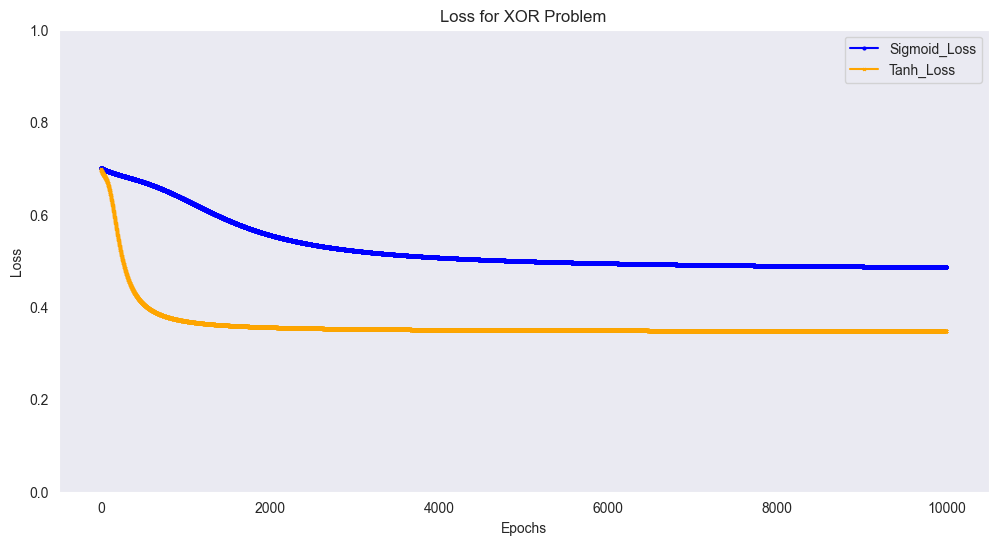

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# XOR input and output
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

# Create the neural network model
model_sigmoid = Sequential()
model_sigmoid.add(LinearLayer(2,2))
model_sigmoid.add(SigmoidLayer())
model_sigmoid.add(LinearLayer(2,1))
model_sigmoid.add(SigmoidLayer())

epochs = 10000
learning_rate = 0.1
sigmoid_losses = []

for epoch in range(epochs):
    predicted = model_sigmoid.forward(X)

    loss_layer = BinaryCrossEntropyLoss()
    loss = loss_layer.forward(predicted,y)
    sigmoid_losses.append(loss)

    loss_grad = loss_layer.backward(predicted,y)
    model_sigmoid.backward(loss_grad)

    model_sigmoid.update(learning_rate)

    if epoch%1000==0:
        print(f'Epoch {epoch},Loss: {loss}')

predicted = model_sigmoid.forward(X)
predicted_classes = (predicted > 0.5).astype(int)

print("Sigmoid Outputs:")
print(predicted_classes)
save_weights(model_sigmoid,'sigmoid_xor.w')

# Create the neural network model with Tanh
model_tanh = Sequential()
model_tanh.add(LinearLayer(2, 2))
model_tanh.add(Tanh())
model_tanh.add(LinearLayer(2, 1))
model_tanh.add(SigmoidLayer())

tanh_losses = []

for epoch in range(epochs):
    predicted = model_tanh.forward(X)

    loss_layer = BinaryCrossEntropyLoss()
    loss = loss_layer.forward(predicted,y)
    tanh_losses.append(loss)

    loss_grad = loss_layer.backward(predicted,y)
    model_tanh.backward(loss_grad)
    model_tanh.update(learning_rate)

    if epoch % 1000 == 0:
        print(f'Epoch {epoch},Loss: {loss}')

predicted = model_tanh.forward(X)
predicted_classes = (predicted>0.5).astype(int)

print("Tanh Outputs:")
print(predicted_classes)
save_weights(model_tanh, 'Tanh_xor.w')

plt.figure(figsize=(12, 6))
plt.plot(sigmoid_losses, label='Sigmoid_Loss',color='blue',marker='o',markersize=2)
plt.plot(tanh_losses, label='Tanh_Loss',color='orange',marker='x',markersize=2)
plt.title('Loss for XOR Problem')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# sigmoid performed better than tanh as tanh took more epochs to reduce the loss

In [5]:
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]
X_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N


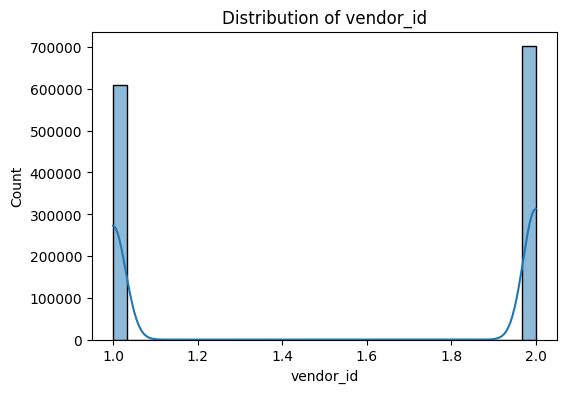

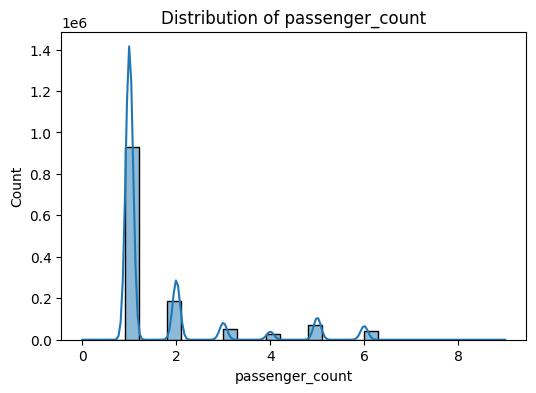

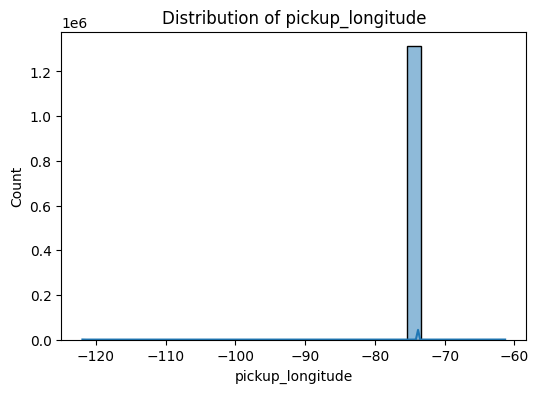

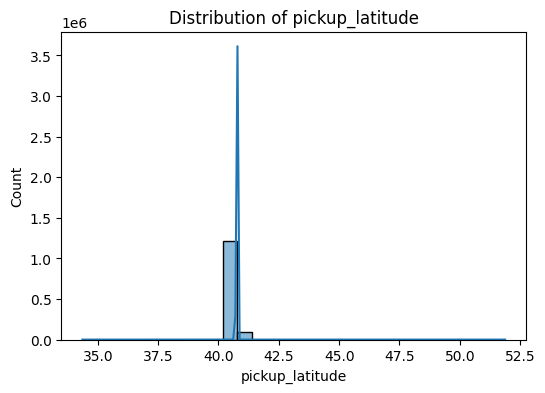

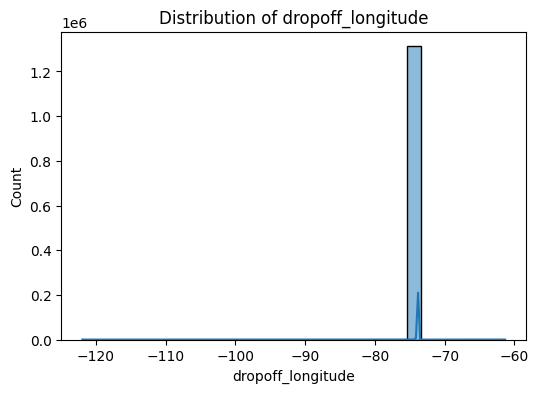

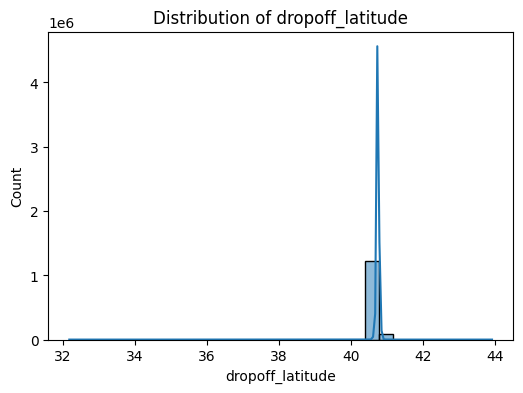

In [ ]:
import pandas as pd

# Assuming `data` is your DataFrame
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_columns:
    plt.figure(figsize=(6,4))
    sns.histplot(X_train[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

In [25]:
# Separate DOC

# kept only 4 columns latitude and longitude for pickup and dropoff
# converted it to DataFrame
# changed the datatype to float
# performed scaling for easy training

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

columns_to_drop = ['id','vendor_id','pickup_datetime','dropoff_datetime','passenger_count','store_and_fwd_flag']
X_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
X_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Standardizing the features
scaler = StandardScaler()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train,X_val,y_train,y_val = train_test_split(X_train_scaled,y_train,test_size=0.2,random_state=42)

y_train = y_train.to_numpy() if isinstance(y_train,pd.Series) else y_train
y_val = y_val.to_numpy() if isinstance(y_val,pd.Series) else y_val
y_test = y_test.to_numpy() if isinstance(y_test,pd.Series) else y_test

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("Data preprocessing completed.")
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test_scaled.shape}")

Data preprocessing completed.
Training set size: (1050223, 4)
Validation set size: (262556, 4)
Test set size: (145865, 4)


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def mean_squared_error(predictions:np.ndarray,targets:np.ndarray) -> float:
    targets_array = targets.reshape(-1,1) if targets.ndim == 1 else targets
    return np.mean((predictions-targets_array)**2)

def compute_gradient(predictions:np.ndarray,targets:np.ndarray) -> np.ndarray:
    targets_array = targets.reshape(-1,1) if targets.ndim == 1 else targets
    return 2 * (predictions-targets_array)/len(targets_array)

def model(model,X_train,y_train,X_val,y_val,learning_rate=0.001,epochs=50):
    training_losses = []
    val_losses = []

    for epoch in range(epochs):
        predictions = model.forward(X_train)
        loss = mean_squared_error(predictions,y_train)
        training_losses.append(loss)

        gradient = compute_gradient(predictions,y_train)
        model.backward(gradient)

        for layer in model.layers:
            if isinstance(layer, LinearLayer):
                layer.weights -= learning_rate * layer.weights_grad
                layer.bias -= learning_rate * layer.bias_grad

        val_predictions = model.forward(X_val)
        val_loss = mean_squared_error(val_predictions,y_val)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {loss:},Val Loss: {val_loss:}")
    return training_losses, val_losses

/var/folders/d2/my0s5s196wnclqdm48pfl9140000gn/T/ipykernel_11225/82029245.py:38: RuntimeWarning: overflow encountered in exp
  self.output = 1/(1 + np.exp(-input))


Epoch [10/50], Training Loss: 31140989.258915443,Val Loss: 25455438.247829013
Epoch [20/50], Training Loss: 30959176.625580844,Val Loss: 25276341.673671342
Epoch [30/50], Training Loss: 30815789.977107804,Val Loss: 25133170.850844435
Epoch [40/50], Training Loss: 30701462.56243835,Val Loss: 25020497.764922608
Epoch [50/50], Training Loss: 30618654.5389955,Val Loss: 24938640.77141824


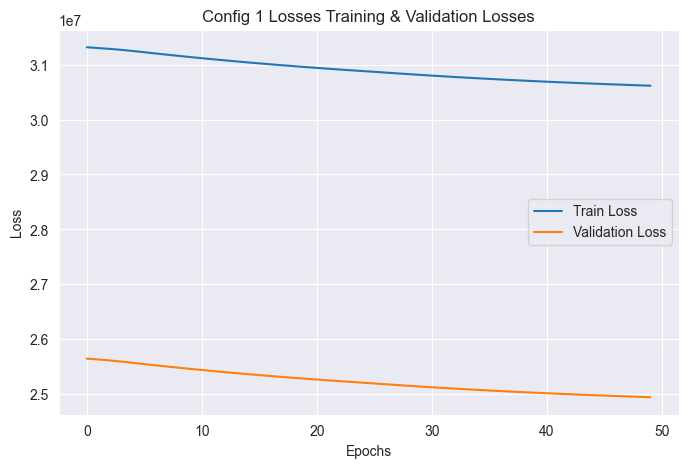

In [10]:
model1 = Sequential()
model1.add(LinearLayer(4, 8))
model1.add(SigmoidLayer())
model1.add(LinearLayer(8, 8))
model1.add(SigmoidLayer())
model1.add(LinearLayer(8, 1))

train_loss1, val_loss1 = model(
    model1,
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=0.001
)

test_preds1 = model1.forward(X_test)

def visualize_losses(train_loss_data, val_loss_data, label):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_data, label="Train Loss")
    plt.plot(val_loss_data, label="Validation Loss")
    plt.title(f'{label} Training & Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_{label.lower().replace(" ", "_")}.png')
    plt.show()

visualize_losses(train_loss1, val_loss1, 'Config 1 Losses')
print()

In [11]:
rmse_train_loss1 = np.sqrt(train_loss1[-1])
rmse_val_loss1 = np.sqrt(val_loss1[-1])
print(f"Training RMSE : {rmse_train_loss1:}")
print(f"Validation RMSE : {rmse_val_loss1:}")

Training RMSE : 5533.412558177413
Validation RMSE : 4993.860307559497


/var/folders/d2/my0s5s196wnclqdm48pfl9140000gn/T/ipykernel_11225/82029245.py:38: RuntimeWarning: overflow encountered in exp
  self.output = 1/(1 + np.exp(-input))


Epoch [10/50], Training Loss: 30998238.920969427,Val Loss: 25300625.74712798
Epoch [20/50], Training Loss: 30753711.176950037,Val Loss: 25065001.548245933
Epoch [30/50], Training Loss: 30609317.61810737,Val Loss: 24925221.064820115
Epoch [40/50], Training Loss: 30524060.094955664,Val Loss: 24842189.65403945
Epoch [50/50], Training Loss: 30473720.01013255,Val Loss: 24792781.45401505


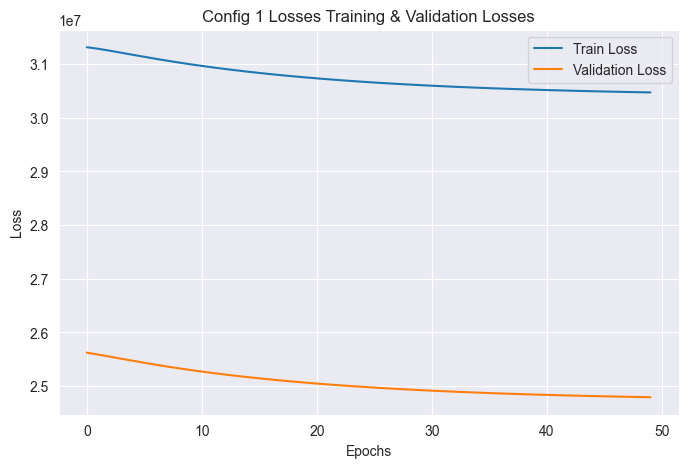

In [12]:
model2 = Sequential()
model2.add(LinearLayer(4, 20))
model2.add(SigmoidLayer())
model2.add(LinearLayer(20,20))
model2.add(SigmoidLayer())
model2.add(LinearLayer(20, 15))
model2.add(SigmoidLayer())
model2.add(LinearLayer(15, 1))

train_loss2, val_loss2 = model(
    model2,
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=0.001
)

test_preds2 = model2.forward(X_test)

def visualize_losses(train_loss_data, val_loss_data, label):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_data, label="Train Loss")
    plt.plot(val_loss_data, label="Validation Loss")
    plt.title(f'{label} Training & Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_{label.lower().replace(" ", "_")}.png')
    plt.show()

visualize_losses(train_loss2, val_loss2, 'Config 1 Losses')
print()

In [ ]:
rmse_train_loss2 = np.sqrt(train_loss2[-1])
rmse_val_loss2 = np.sqrt(val_loss2[-1])
print(f"Training RMSE : {rmse_train_loss2:}")
print(f"Validation RMSE : {rmse_val_loss2:}")

Training RMSE : 5521.763582532125
Validation RMSE : 4980.86773129724


<ipython-input-2-5b44cb189a77>:38: RuntimeWarning: overflow encountered in exp
  self.output = 1/(1 + np.exp(-input))


Epoch [10/50], Training Loss: 31079962.4158,Val Loss: 25389952.0133
Epoch [20/50], Training Loss: 30873187.9956,Val Loss: 25187745.6635
Epoch [30/50], Training Loss: 30729398.6739,Val Loss: 25046745.3083
Epoch [40/50], Training Loss: 30629409.5161,Val Loss: 24948371.4074
Epoch [50/50], Training Loss: 30559878.1586,Val Loss: 24879692.9445


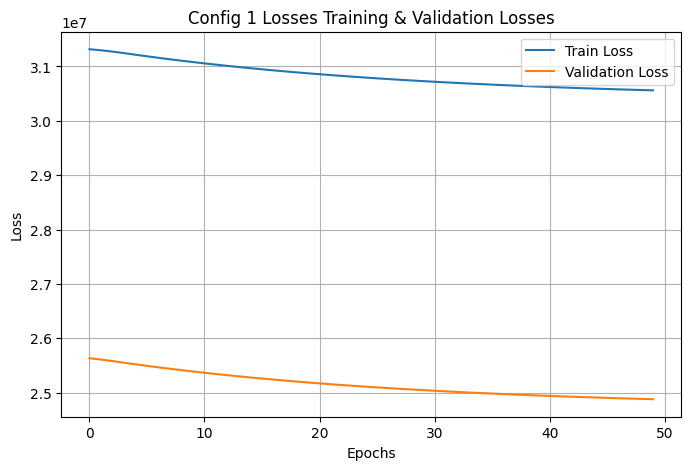

In [ ]:
model3 = Sequential()
model3.add(LinearLayer(4, 20))
model3.add(SigmoidLayer())
model3.add(LinearLayer(20, 10))
model3.add(SigmoidLayer())
model3.add(LinearLayer(10, 1))

train_loss3, val_loss3 = model(
    model3,
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=0.001
)

test_preds3 = model3.forward(X_test)

def visualize_losses(train_loss_data, val_loss_data, label):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_data, label="Train Loss")
    plt.plot(val_loss_data, label="Validation Loss")
    plt.title(f'{label} Training & Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_{label.lower().replace(" ", "_")}.png')
    plt.show()

visualize_losses(train_loss3, val_loss3, 'Config 1 Losses')
print()

In [ ]:
rmse_train_loss3 = np.sqrt(train_loss3[-1])
rmse_val_loss3 = np.sqrt(val_loss3[-1])
print(f"Training RMSE : {rmse_train_loss3:}")
print(f"Validation RMSE : {rmse_val_loss3:}")

Training RMSE : 5528.09896425967
Validation RMSE : 4987.954785729707
